# Imports

In [1]:
import pandas as pd
import yfinance as yf

# Scraping the Dow Jones Constituents

In [2]:
pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"); #list of dataframe objects for each table

In [3]:
const = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")[1]

In [5]:
const[:1]

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting
0,3M,NYSE,MMM,Conglomerate,1976-08-09,As Minnesota Mining and Manufacturing,3.84%


In [7]:
const = const.iloc[:, :5]

In [8]:
const.rename(columns = {"Date added":"Date_Added"}, inplace = True)

In [9]:
const.Date_Added = pd.to_datetime(const.Date_Added)

In [10]:
const[:1]

,Company,Exchange,Symbol,Industry,Date_Added
0,3M,NYSE,MMM,Conglomerate,1976-08-09


In [71]:
const.to_csv("const.csv", index = False)

## Loading Historical Dow Jones Prices

In [11]:
dji = yf.download("^DJI",start="2001-01-01",end="2021-05-01")

[*********************100%***********************]  1 of 1 completed


In [12]:
dji.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,10790.919922,10797.019531,10585.360352,10646.150391,10646.150391,253300000
2001-01-03,10637.419922,11019.049805,10581.089844,10945.750000,10945.750000,420720000
2001-01-04,10944.940430,11028.000000,10888.419922,10912.410156,10912.410156,382800000
2001-01-05,10912.809570,10919.419922,10627.750000,10662.009766,10662.009766,272650000
2001-01-08,10658.730469,10700.849609,10516.019531,10621.349609,10621.349609,225780000


In [73]:
dji.to_csv("dji.csv")

In [38]:
# Data to work with 

close = dji.loc["2010-01-01": "2020-03-31", "Close"].to_frame()
close["Return"] = df.pct_change()
close.rename(columns = {"Close":"DJI_Close", "Return":"DJI_Return"}, inplace = True)

## Visualization

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use("ggplot")

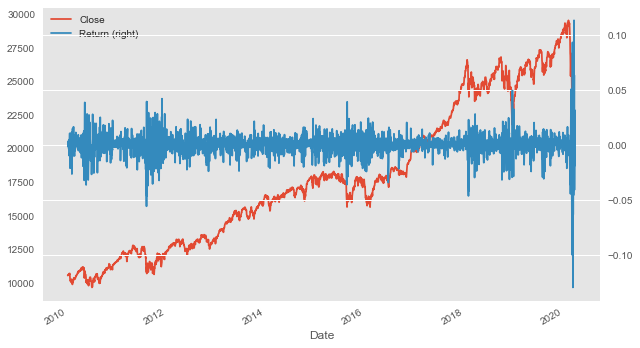

In [37]:
close.plot(figsize = (10,6),secondary_y = "Return", mark_right = True)
plt.show()

## Backtesting Strategies

Testing buy and hold versus a variety of backtesting strategies.

1:  Investing in DJI (__long__ position) <br>
-1: Short Selling DJI (__short__ position)<br>
0:  No position (__neutral__)

In [46]:
#Function for comparing return/risk of a strategy vs buy and hold 

def summary_ann(returns):
    summary = returns.agg(["mean", "std"]).T #Transpose for easy selection and computations
    summary["Return"] = summary["mean"] * 252 #252 Trading days
    summary["Risk"] = summary["std"] * np.sqrt(252)
    summary.drop(columns = ["mean", "std"], inplace = True)
    return summary

### Simple Momentum

__a) Investing (+1)__ into DJI tomorrow if today´s return was __positive__ <br>
__b) Short selling (-1)__ DJI tomorrow if today´s return was __negative__

In [40]:
df = close.copy()

In [41]:
df["Position"] = np.sign(df["DJI_Return"]) # 1 if > 0 else -1
df["Strategy_Ret"] = df["Position"].shift() * df["DJI_Return"]

In [42]:
df.head(2)

,DJI_Close,DJI_Return,Position,Strategy_Ret
Date,,,,
2010-01-04,10583.959961,NaN,NaN,NaN
2010-01-05,10572.019531,-0.001128,-1.0,NaN


In [43]:
#Cumalitive price using simple backtesting

df["Strategy"] = df.Strategy_Ret.add(1, fill_value = 0).cumprod() * df.iloc[0, 0] #Multiply by intitial price

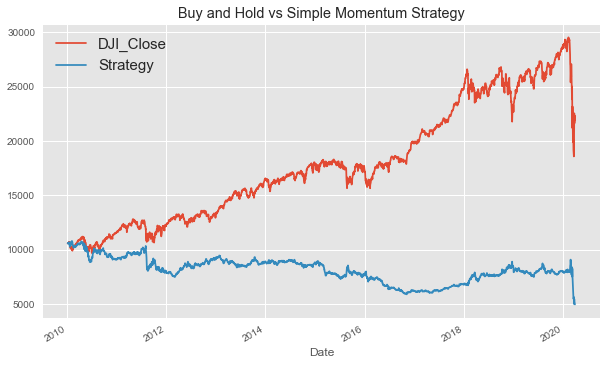

In [45]:
df[["DJI_Close", "Strategy"]].plot(figsize = (10,6))
plt.title("Buy and Hold vs Simple Momentum Strategy")
plt.legend(fontsize = 15)
plt.show()

In [47]:
summary_ann(df[["DJI_Return", "Strategy_Ret"]])

,Return,Risk
DJI_Return,0.085381,0.167966
Strategy_Ret,-0.059742,0.168010


### Simple Contrarian

a.)  __Short Selling (-1)__ DJI tomorrow if today´s return was __positive__ <br>
b.)  __Investing (+1)__ into DJI tomorrow if today´s return was __negative__

In [49]:
df = close.copy()

In [50]:
df["Position"] = -np.sign(df["DJI_Return"]) #Note the minus sign
df["Strategy_Ret"] = df["Position"].shift() * df["DJI_Return"]
df["Strategy"] = df.Strategy_Ret.add(1, fill_value = 0).cumprod() * df.iloc[0, 0]

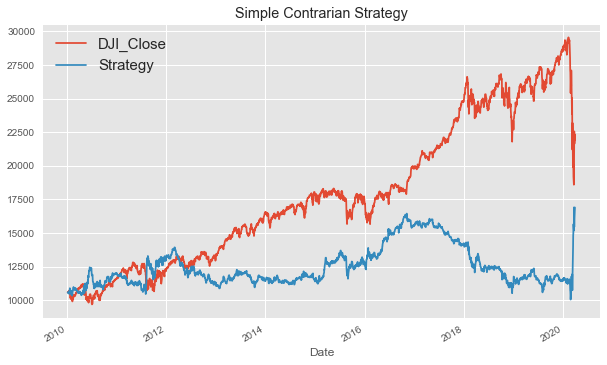

In [51]:
df[["DJI_Close", "Strategy"]].plot(figsize = (10,6))
plt.legend(fontsize = 15)
plt.title("Simple Contrarian Strategy")
plt.show()

In [52]:
summary_ann(df[["DJI_Return", "Strategy_Ret"]])

,Return,Risk
DJI_Return,0.085381,0.167966
Strategy_Ret,0.059742,0.168010


### Contrarian with condition

a.)  __Short Selling (-1)__ DJI tomorrow if today´s return was __positive__ and __> 0.01__ <br>
b.)  __Investing (+1)__ into DJI tomorrow if today´s return was __negative__

In [53]:
df = close.copy()

In [54]:
df["Position"] = np.where(df["DJI_Return"] > 0.01, -1, 1)
df["Strategy_Ret"] = df["Position"].shift() * df["DJI_Return"]
df["Strategy"] = df.Strategy_Ret.add(1, fill_value = 0).cumprod() * df.iloc[0, 0]

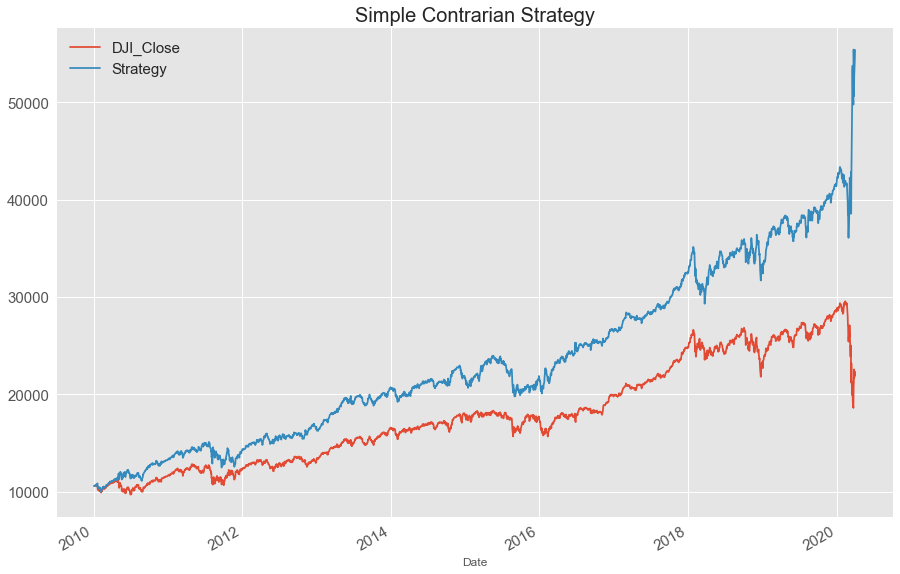

In [55]:
df[["DJI_Close", "Strategy"]].plot(figsize = (15, 10), fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Simple Contrarian Strategy", fontsize = 20)
plt.show()

In [56]:
summary_ann(df[["DJI_Return", "Strategy_Ret"]])

,Return,Risk
DJI_Return,0.085381,0.167966
Strategy_Ret,0.175813,0.167686


Note: 

Even though strategy out performed buy and hold, its important to consider transaction costs, tax effects and to perform forward testing before implementation.

## Simple Moving Averages

In [57]:
df = close.copy()

In [58]:
df["SMA50"] = df.DJI_Close.rolling(window = 50).mean()
df["SMA200"] = df.DJI_Close.rolling(window = 200).mean()

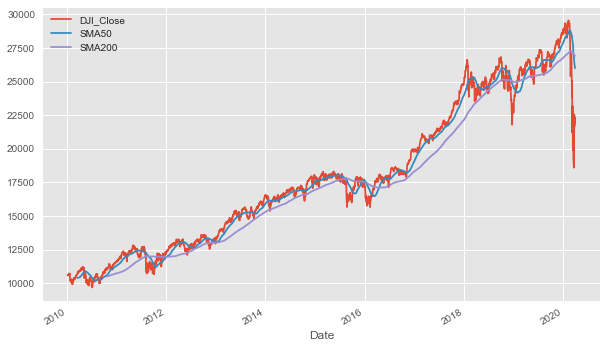

In [60]:
df[["DJI_Close","SMA50", "SMA200"]].plot(figsize = (10,6))
plt.legend()
plt.show()

### Momentum SMA Strategy

__a) Investing (+1)__: SMA50 __>__ SMA200 <br>
__b) Short Selling (-1)__: SMA50 __<__ SMA200

In [61]:
df["Position"] = np.sign(df.SMA50.sub(df.SMA200)) 

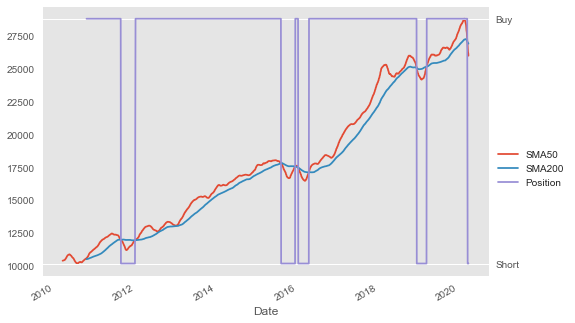

In [62]:
ax = df[["SMA50","SMA200","Position"]].plot(secondary_y="Position", mark_right=False, legend=False)
ax.right_ax.set_yticks([-1,1])
ax.right_ax.set_yticklabels(['Short','Buy'])

h1, l1 = ax.get_legend_handles_labels() #This is the blue and green lines, and the string label #NOT locations
h2, l2 = ax.right_ax.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, bbox_to_anchor = (1,0.5)) #Have to use plt because the position is relative to the figure and not ax 

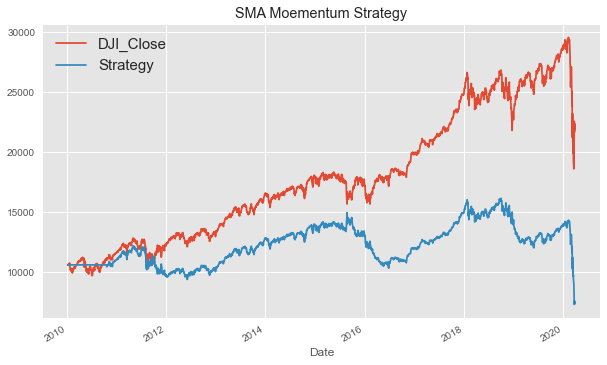

In [65]:
df["Strategy_Ret"] = df["Position"].shift() * df["DJI_Return"]
df["Strategy"] = df.Strategy_Ret.add(1, fill_value = 0).cumprod() * df.iloc[0, 0]

df[["DJI_Close", "Strategy"]].plot(figsize = (10,6))
plt.legend(fontsize = 15)
plt.title("SMA Moementum Strategy")
plt.show()

In [66]:
summary_ann(df[["DJI_Return", "Strategy_Ret"]])

,Return,Risk
DJI_Return,0.085381,0.167966
Strategy_Ret,-0.022490,0.167761


### Contrarian SMA Strategy

In [67]:
df["Position"] = -np.sign(df.SMA50.sub(df.SMA200)) 

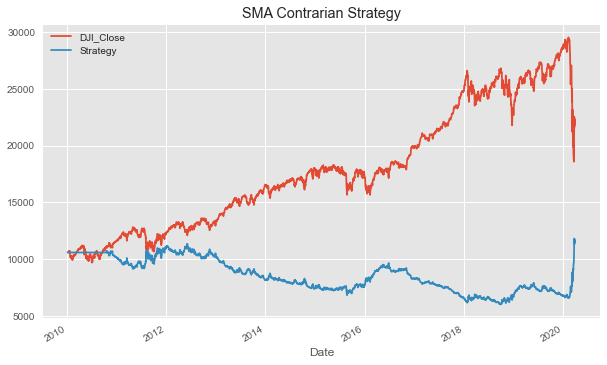

In [70]:
df["Strategy_Ret"] = df["Position"].shift() * df["DJI_Return"]
df["Strategy"] = df.Strategy_Ret.add(1, fill_value = 0).cumprod() * df.iloc[0, 0]

df[["DJI_Close", "Strategy"]].plot(figsize = (10,6))
plt.legend()
plt.title("SMA Contrarian Strategy")
plt.show()